# Workshop-6 Time Series Classification

## Import and data

In [1]:
!pip install -U pyts
!pip install -U tslearn
!pip install -U sktime

  Attempting uninstall: tslearn
    Found existing installation: tslearn 0.5.0.5
    Uninstalling tslearn-0.5.0.5:
      Successfully uninstalled tslearn-0.5.0.5


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import pandas as pd


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    For testing time series classifiers we will use small dataset <b>GunPoint</b> from <code>pyts</code> library.
The dataset involves one female actor and one male actor making a motion with their hand. 
The two classes are:<ul>
<li>Gun-Draw: the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. 
<li>Point: the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. </ul>
For both classes, it is tracked the centroid of the actor’s right hands in both X- and Y-axes, which appear to be highly correlated. 

In [56]:
from sktime.datasets import load_gunpoint

x_train, y_train = load_gunpoint(split="TRAIN", return_X_y=True, return_type="numpy3D")
x_test, y_test = load_gunpoint(split="TEST", return_X_y=True, return_type="numpy3D")

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Let's investigate it and visualize.

class lables ['1' '2']
train x (50, 1, 150) train labels (50,) test x (150, 1, 150) test labels (150,)


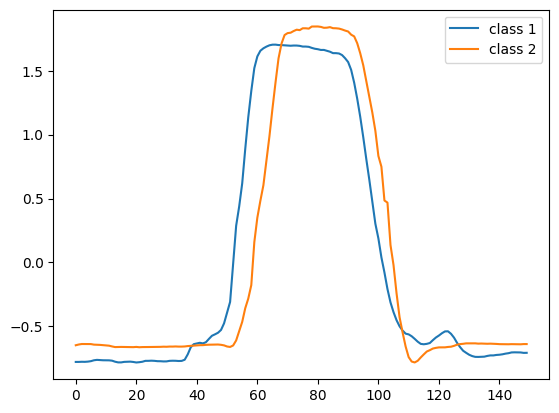

In [57]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
print('class lables',classes)
print('train x', x_train.shape, 'train labels', y_train.shape,'test x', x_test.shape,'test labels', y_test.shape)

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0, 0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
<b>SKTime library</b> <u>  use a vary specific format of data In the classification tasks</u>.<br>You may read about 
    <a href="https://github.com/alan-turing-institute/sktime/blob/main/examples/loading_data.ipynb" title="">here</a>.

The utilities `sktime.datatypes.convert` and `sktime.datatypes.convert_to` can be used to convert between a number of common time series formats.

NOTE: we could have already loaded the data in our preferred format by using the `return_type` argument in `load_gunpoint`.

In [63]:
from sktime.datatypes import convert_to

X_train = convert_to(x_train, "nested_univ")
X_test  = convert_to(x_test, "nested_univ")
X_train.head()


,var_0
0,0 -0.647885 1 -0.641992 2 -0.63818...
1,0 -0.644427 1 -0.645401 2 -0.64705...
2,0 -0.778353 1 -0.778279 2 -0.77715...
3,0 -0.750060 1 -0.748103 2 -0.74616...
4,0 -0.599539 1 -0.597422 2 -0.59926...


## Classification learning

### Sklearn case

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    For the first let's try SKlearn classifier as baseline.<ul>

`sklearn` wants 2D numpy arrays, so we will remove the middle dimension.

In [80]:
x_train_2d = x_train.squeeze(1)
x_test_2d = x_test.squeeze(1)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [81]:
# let's get a baseline for comparison
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train_2d, y_train)
classifier.score(x_test_2d, y_test)


0.92

### Sktime univariate classifier

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    <b> Time series tree </b><br>
Time series tree is a modification of the classification tree algorithm to the time series setting:<ul>
<li>Split the series into random intervals,
<li>Extract features (mean, standard deviation and slope) from each interval,
<li>Train a decision tree on the extracted features

In [82]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sklearn.tree import DecisionTreeClassifier
from sktime.utils.slope_and_trend import _slope
from sktime.pipeline import make_pipeline

steps = [
    RandomIntervalFeatureExtractor(
        n_intervals="sqrt", 
        features=[np.mean, np.std, _slope]),
    DecisionTreeClassifier(),
]

time_series_tree = make_pipeline(*steps)
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.8333333333333334

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    <b> Time series Forest </b><ul>
    Actually, we can ensamble a several trees for increasing accuracy and robustness.

In [84]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100)
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9666666666666667

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul>
    <ul> 
Actually we can use <b>built-in Time Series Forest Classifier (TSF)</b>.<ul>
        TSF here is an ensemble of tree classifiers built on the summary statistics of randomly selected intervals. For each tree sqrt(series_length) intervals are randomly selected. From each of these intervals the mean, standard deviation and slope is extracted from each time series and concatenated into a feature vector. These new features are then used to build a tree, which is added to the ensemble.

In [85]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
tsf = TimeSeriesForestClassifier(n_estimators=100, random_state=47)
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9666666666666667

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    <b> Random Interval Spectral Ensemble (RISE) </b><ul>
Another popular variant of time series forest is the so-called Random Interval Spectral Ensemble (RISE), which makes use of several series-to-series feature extraction transformers, including:<ul>
<li>Fitted auto-regressive coefficients,
<li>Estimated autocorrelation coefficients,
 <li>Power spectrum coefficients.</ul>
Similar to Time series Forest here all feature extraction are made on random intervals of time series for a several trees.    

In [38]:
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=10, random_state=47)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.94

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    <b> Dynamic Time Warping Distance based Classifier </b><ul>
For time series, the most popular k-nearest-neighbours algorithm is based on dynamic time warping (dtw) distance measure.
<br> 
The <b>DTW algorithm</b> has the follows steps:<ol>
<li> Calculate the distance between the first point in the first series segment and every point in the second series. <br>Select the minimum of the calculated values and store it (this is the "time warp" stage). <br> 
<li> Move to the second point and repeat stage 1.<br> Move step by step along points and repeat stage 1 till all points are exhausted.<br>
<li> Calculate and Select the minimum of  distances between the first point in the second series segment and every point in the first series.<br>
<li> Move step by step along points in the second segment and repeat stage 3 till all points are exhausted.
<li> Sum all the stored minimum distances.<br>
    </ol>
<!--
https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950
-->
  
The <b>DTW algorithm</b> can be formally described as<br>  
$$
\begin{align}
& D(i,j)=0\\\\
& D(i,j) = dist(x_i,y_j) + min\{D(i-1,j), D(i,j-1),  D(i-1,j-1) \}\\\\
& d_{DWT} = min_i\frac{\sum_{j=0}^{K}D(i,j)}{K}\\
\end{align}
$$    
    
 where <ul> 
  <li>  $D$ is the element of virtual matrix of time wrapping with elements $D(i,j)$ and size $M_x\times M_y$;<br>
  <li>   $dist$ is the distance function (for instance, Euclidian distance, or MAE);<br>
  <li>   $x$ and $y$ are the series segments with length $M_x$ and $M_y$ correspondingly. Thus here length of segments can be non-equal;<br>
  <li>   $K$ is the length of virtual trajectory build form right bottom of the matrix $D$ ($D(M_x,M_y)$) to the up-left point ($D(0,0)$) such that its sum is minimal).
</ul>   
Example of DTW calculation

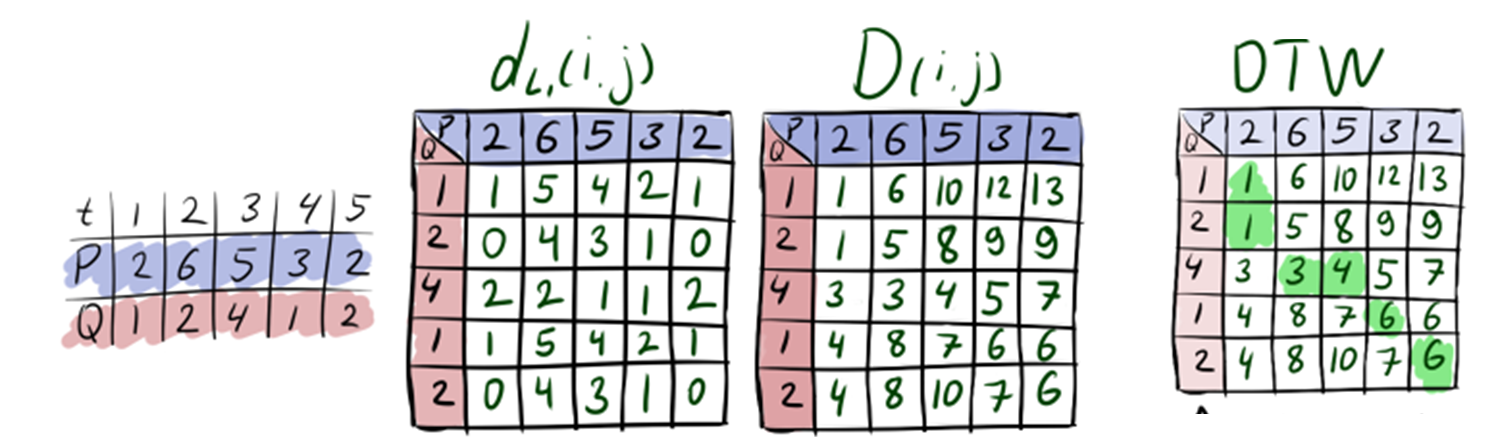

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul>
    <b>Dynamic Time Wrapping (DTW)</b><ul>
Non-linear algorithm, based on the searching of maximum similarity between points independently of its index position.<br>
    Actually this algorithm in combination with K Nearest Neighbors can be considered as baseline for all time series classification. 
<br>   
The main <b>advantage of the DTW</b> distance is the independence (invariation) to the shifts or other slight changes in the segments (like its squeezing and stretching). <br>In other words DTW method try to build a matrix of mapping (or transformation) of one segment to another, and find the best (minimum cost distance between them).<br>
<br> The main <b>drawback of the DTW</b> is the high complexity and implicity of similarity search. Thus in some cases the DTW can show similarity where it should not be.
<br>    
<!-- https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html -->
<em>Note</em> Here we will use the so-called derivative dtw distance - distance of time series differences.

In [8]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9866666666666667

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    <b> Dictionary based  Classifier </b><ul>
Dictionary based approaches adapt the bag of words model commonly used in signal processing, computer vision and audio processing for time series classification. Dictionary based classifiers have the same broad structure. A sliding window of length $w$ is run across a series. For each window, the real valued series of length $w$ is converted through approximation and discretisation processes into a symbolic string of length $l$, which consists of $\alpha$ possible letters. The occurrence in a series of each 'word' from the dictionary defined by $l$ and $\alpha$ is counted, and once the sliding window has completed the series is transformed into a histogram. Classification is based on the histograms of the words extracted from the series, rather than the raw data.<br>
    Among the all Dictionary based  Classifier  we will considering <b>  Bag of SFA Symbols (BOSS) </b>.<ul>
      <b>  Bag of SFA Symbols (BOSS) </b><ul>
BOSS is an ensemble of individual BOSS classifiers making use of the <b>SFA (Symbolic Fourier Approximation)</b> transform. The classifier performs grid-search through a large number of individual classifiers for parameters $l$, $\alpha$, $w$ and $p$ (normalise each window). Of the classifiers searched only those within 92\% accuracy of the best classifier are retained. Individual BOSS classifiers use a non-symmetric distance function, BOSS distance, in conjunction with a nearest neighbour classifier.<ul>
    <b> Contractable BOSS (cBOSS)</b><ul>
cBOSS significantly speeds up BOSS with no significant difference in accuracy by improving how the ensemble is formed. cBOSS utilises a filtered random selection of parameters to find its ensemble members. Each ensemble member is built on a 70% subsample of the train data, using random sampling without replacement. An exponential weighting scheme for the predictions of the base classifiers is introduced.
<!-- 
A new parameter for the number of parameters samples $k$ is introduced. of which the top $s$ (max ensemble size) with the highest accuracy are kept for the final ensemble. The $k$ parameter is replaceable with a time limit $t$ through contracting. -->

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'><ul>
  


In [16]:
from sktime.classification.dictionary_based import ContractableBOSS, TemporalDictionaryEnsemble
boss = ContractableBOSS(random_state=47,max_ensemble_size=100)
boss.fit(X_train, y_train)
boss.score(X_test, y_test)

0.9933333333333333

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
<b> Shapelets Classifiers </b><br>
Shapelets are defined in as subsequences of series (or series segment), that are in some sense maximally representative of a class.<br> If it is assumed a binary classification task. A shapelet is a the series part (interval, range), that represent by some measure in most series of one class and absent from series of the other class. 
    <ul style='margin-bottom:-70px'>    
<b> ROCKET Classifer </b><br>
ROCKET Classifer is type of the Shapelets-based classifers is based on the so-called <b>ROCKET transforms</b>.<ul> 
    <li> The <b>ROCKET transforms</b> are the time series transforms using random convolutional kernels (random length, weights, bias, dilation, and padding).
    <li> ROCKET Classifer computes two features from the resulting feature maps (after transformations): the max value, and the proportion of positive values to all (ppv).
    <li> The transformed features are used to train a linear classifier.

In [9]:
from sktime.classification.shapelet_based import ROCKETClassifier
shapelet = ROCKETClassifier(random_state=47)
shapelet.fit(X_train, y_train)
shapelet.score(X_test, y_test)

0.9933333333333333

### Exercise 1

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
1. Working with built-in data.<ol>
    <li> Load dataset <code>load_italy_power_demand</code> from <code>sktime.datasets</code>.
        <ul> use <code>split="train", return_X_y=True</code> for train data and <br>
            and <code>split="test", return_X_y=True</code> for test data. </ul>
    <li> cut test part to 50 instances.
    <li> Try to visualize instances.
    <li> Choose 4 SKlearn and 4 SKTIme classifiers for this dataset.
</ol>
    
<blockquote>    
<details>
  <summary> $\Rightarrow$ tap for hint</summary>
 You may use the following code for load dataset:
      
```python
from sktime.datasets import load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train", return_X_y=True)
X_test, y_test   = load_italy_power_demand(split="test", return_X_y=True)
X_test = X_test[:50]
y_test = y_test[:50]

print('train:',X_train.shape, y_train.shape,'test:', X_test.shape, y_test.shape)
labels, counts = np.unique(y_train, return_counts=True)
print('labels:',labels,'num of instances:', counts)

#visualization
plt.figure(figsize=plt.figaspect(0.25), dpi=100)
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(label=f"class {label}")
plt.legend()
plt.show()
```
   
</details>    

<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
2. Find the best classifier for the dataset from the internet <ol>
<li> Load the following data set from the link:<br>
    <a href="https://raw.githubusercontent.com/jbrownlee/Datasets/master/IndoorMovement.zip"> https://raw.githubusercontent.com/jbrownlee/Datasets/master/IndoorMovement.zip </a><br>
<li> Crate  directory <code>Indoor</code> and unzip dataset in this directory.
<li> The dataset include a signals (time series) from people moving  through 2 rooms. <ul>
    Signals are taken form 4 sensors.<br>
    Signals divided into 3 paths (groups), of how people moving<br>
    and two classes (targets):<ul>
    <li>"1" - when human transit between two rooms
    <li>"-1" - when human no-transit between two rooms
    </ul></ul>
 <li> The task is to classify transition between rooms by those sensors.
    </ol>
    For the first let's load data.
    
 ><em> The task is inspired by this tutorial: https://machinelearningmastery.com/indoor-movement-time-series-classification-with-machine-learning-algorithms/ </em>

In [116]:
import os      
 
def load_dataset(prefix='Indoor/'):
    '''
    load_dataset of Indoor Movements.
    
    Parameters
    -----------
    prefix: str
        path to the directory with the dataset
    
    Returns
    -----------
    sequences: list,
        data of 4-th sensors for each instance (human).
    targets: 1d ndarray,
        targets for each instance +1 or -1.
    groups: 1d ndarray,
        group id for each instance 1,2 or 3.
       
    '''
    grps_dir, data_dir = prefix+'groups/', prefix+'dataset/'

    # load mapping files
    targets = pd.read_csv(data_dir + 'MovementAAL_target.csv', header=0)
    groups  = pd.read_csv(grps_dir + 'MovementAAL_DatasetGroup.csv', header=0)
    paths   = pd.read_csv(grps_dir + 'MovementAAL_Paths.csv', header=0)

    # load traces
    sequences = list()
    
    for name in os.listdir(data_dir):
        
        filename = os.path.join(data_dir,name)
        
        if filename.endswith('_target.csv'): continue
            
        df = pd.read_csv(filename, header=0)   
        
        values = df.values.reshape(-1,1)
        
        sequences.append(values.tolist())     
 
    return sequences, targets.values[:,1], groups.values[:,1]



In [118]:
sequences, targets, groups =load_dataset(prefix='Indoor/')

labels, counts = np.unique(targets, return_counts=True)
print('targets',labels, counts)
labels, counts = np.unique(groups, return_counts=True)
print('targets',labels, counts)

targets [-1  1] [156 158]
targets [1 2 3] [104 106 104]


<font size=4.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    Now we create datasets. <br>
We will use 1 and second groups as train data and 3 group as test data.
<br>Please note, that all data has different length and we will pad all data
to the maximum length.

In [119]:
def create_dataset(sequences, targets, groups, max_len = None): 
    '''
    Create train and test datasets from raw data.
        The data set is created with padding all instance 
        to the max_len variable. 
        
      Here group 1 and 2 are appended to the train data,
        and froup 3 for test data.
    
    Parameters
    -----------
    sequences: list,
        data of 4-th sensors for each instance (human).
    targets: 1d ndarray,
        targets for each instance +1 or -1.
    groups: 1d ndarray,
        group id for each instance 1,2 or 3.
    max_len: int or None,
        if None: max_len  is the maximum length of instance.
        if int: all instance with length higher will be cut,
            all instance with length smaller 
            will be padded at the end.
    
    Returns
    ---------
    x_train,x_test: 2d ndarrays,
        train and test data.
    y_train,y_test: 1d ndarrays,
        train and test targets (labels).
    
    '''   
    if max_len is None:
        max_len =0
        for i in range(len(sequences)):
            if len(sequences[i])>max_len:
                max_len = len(sequences[i])
    else:
        max_len = int(max_len)
        
    labels, counts = np.unique(groups, return_counts=True)
    
    test_size  = counts[2]
    train_size = counts[0]+counts[1]
    
    x_train = np.zeros((train_size,max_len))
    y_train = np.zeros(train_size)
    
    x_test = np.zeros((test_size,max_len))
    y_test = np.zeros(test_size)
    
    cnt_test  = 0
    cnt_train = 0

    for i in range(len(sequences)):     

        signal = np.squeeze(np.asarray(sequences[i]))
        
        if (max_len-len(signal) >0):
            signal = np.pad(signal,(0,max_len-len(signal)))
        elif (max_len-len(signal) <0):
            signal = signal[:max_len]
            
        
        if groups[i]==3:
            x_test[cnt_test] = signal
            y_test[cnt_test] = targets[i]
            cnt_test +=1
        else:
            x_train[cnt_train] = signal
            y_train[cnt_train] = targets[i]
            cnt_train +=1
    
    return x_train,x_test,y_train,y_test

train : (210, 100) (210,) test : (104, 100) (104,)
1.0


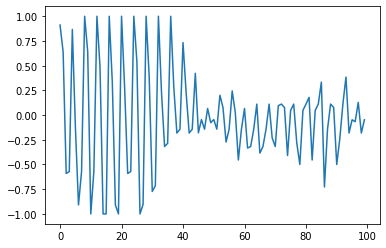

-1.0


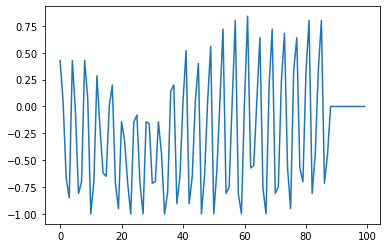

In [120]:
x_train,x_test,y_train,y_test = create_dataset(sequences, targets, groups, max_len = 100)

print('train :',x_train.shape,y_train.shape,'test :', x_test.shape,y_test.shape)

plt.plot(x_train[90])
print(y_train[90])
plt.show()

plt.plot(x_test[100])
print(y_test[100])
plt.show()

<font size=5.5pt  face = 'georgia' style='Line-height :3'><div style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>

<em><u>The task of this exercise is to search for the best classifier for the described problem.</u></em>